Consider wave equation
$$
\partial_t^2 f(t,x) = c^2 \partial_x^2 f(t,x)
$$
for $x \in [0,L]$ and $t \in [0,\infty)$ with boundary and initial conditions
$$
f(t,0) = 0 = f(t,L), \quad f(0,x) = 0, \quad f'(0,x) = \sin(2 \pi x / L)
$$
Analytic solution is
$$
f(t,x) = \frac{L}{2 \pi c} \sin(2 \pi c t / L) \sin(2 \pi x / L)
$$
Here just take $L = 1$ and $c = 1$ for time lenght $t \in [0,2]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import solver2 as solver

/home/virtanej/.conda/envs/deeplearn/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905990597/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


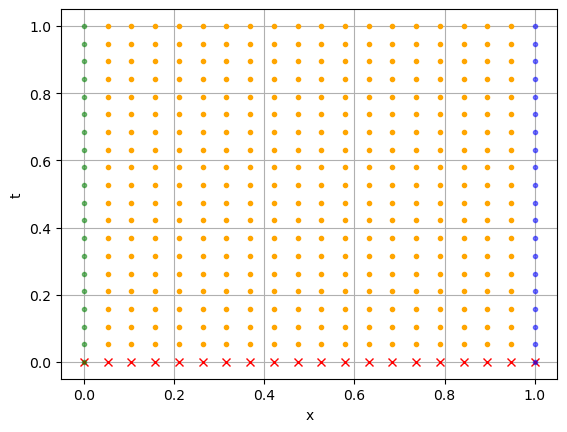

In [2]:
def differential(xt, f):
    # partial_t^2 f(x,t) = partial_x^2 f(x,t)

    # xt shape: [N,2], N = batch size, 2 = (x,t)
    xt = xt.clone().detach().requires_grad_(True)
    
    y = f(xt)

    # grad f(x,t) = [partial_x f(x,t), partial_x f(x,t)]
    grad_y = autograd.grad(y, xt,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    # Extract the partial derivatives
    Dx_y, Dt_y = grad_y[:,0], grad_y[:,1]

    # Second partial derivative w.r.t. x
    D2x_y = autograd.grad(Dx_y, xt,
        grad_outputs=torch.ones_like(Dx_y),
        create_graph=True
    )[0][:,0]

    # Second partial derivative w.r.t. t
    D2t_y = autograd.grad(Dt_y, xt,
        grad_outputs=torch.ones_like(Dt_y),
        create_graph=True
    )[0][:,1]

    return D2t_y - D2x_y


def bc_low(xb, f):
    # f(0,t) = 0
    return f(xb)

def bc_high(xb, f):
    # f(L,t) = 0 where L = 1
    return f(xb)

def ic_dirichlet(xb, f):
    # f(x,0) = 0
    return f(xb)

def ic_neumann(xb, f):
    # f'(x,0) = sin(2 pi x / L) where L = 1
    xb = xb.requires_grad_(True)
    y = f(xb)
    output_shape = torch.ones_like(y)
    gradients = autograd.grad(y, xb, output_shape, create_graph=True)[0]
    Dt_y = gradients[:,1]
    return Dt_y - torch.sin(2*torch.pi*xb[:,0])

x_low = 0.0
x_high = 1.0
t_low = 0.0
t_high = 1.0 # Originally 2.0

# Define domain values, a grid in (x,t) space
num_points_x = 20
num_points_t = 20
mesh_x, mesh_t = torch.meshgrid(torch.linspace(x_low, x_high, num_points_x, dtype=torch.float32), torch.linspace(t_low, t_high, num_points_t, dtype=torch.float32))
domain = torch.cat([mesh_x.reshape(-1, 1), mesh_t.reshape(-1, 1)], dim=1)


# Determine boundary points
boundary_epsilon = 1e-5 # Points within this distance of the boundary are considered boundary points
tb = domain[domain[:,1] <= t_low + boundary_epsilon]
xb_0 = domain[domain[:,0] <= x_low + boundary_epsilon]
xb_L = domain[domain[:,0] >= x_high - boundary_epsilon]

# Remove boundary points from domain
interior_mask = (domain[:,1] > t_low + boundary_epsilon) & (domain[:,0] > x_low + boundary_epsilon) & (domain[:,0] < x_high - boundary_epsilon)
domain = domain[interior_mask]

# Define loss function
bc_tuples = [(bc_low, xb_0), (bc_high, xb_L), (ic_dirichlet, xb_0), (ic_neumann, xb_0)]
loss_fn = solver.LossFunction(differential, bc_tuples, de_weight=2.0, bc_weight=0.1)

# Visualize the domain and boundary points
plt.plot(domain[:,0], domain[:,1], '.', color='orange')
plt.plot(tb[:,0], tb[:,1], 'rx')
plt.plot(xb_0[:,0], xb_0[:,1], 'g.', alpha=0.5)
plt.plot(xb_L[:,0], xb_L[:,1], 'b.', alpha=0.5)
plt.grid()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [3]:
class DummyModel(nn.Module):
    def forward(self, x):
        # x has shape (batch_size, 2) where columns are x_1, x_2
        return x[:,0]**2 + x[:,1]**2

# dummy_model = DummyModel()

# ic_neumann(tb, dummy_model) # Correct value for the dummy mode
# ic_dirichlet(tb, dummy_model) # Correct values
# differential(domain, dummy_model) # Seems to be correct

In [7]:
# Define model
model = nn.Sequential(
    nn.Linear(2, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 1)
)

class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(2*torch.pi*x)

model_sine = nn.Sequential(
    nn.Linear(2, 100),
    Sine(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 1),
)

model = model_sine

epochs = 5000
lr = 0.0002

print("Training model")
loss_data = solver.train(model, loss_fn, domain, epochs, lr, batch_size=64, print_progress=True, print_progress_percentage=0.1)


Training model
Epoch 500/5000 (10.0%) Loss: 0.00029945606365799904
Epoch 1000/5000 (20.0%) Loss: 3.272772300988436e-05
Epoch 1500/5000 (30.0%) Loss: 0.0010258543770760298
Epoch 2000/5000 (40.0%) Loss: 1.2174200492154341e-05
Epoch 2500/5000 (50.0%) Loss: 1.6776248230598867e-05
Epoch 3000/5000 (60.0%) Loss: 4.763010110764299e-06
Epoch 3500/5000 (70.0%) Loss: 4.2236573790432885e-05
Epoch 4000/5000 (80.0%) Loss: 0.00017737240705173463
Epoch 4500/5000 (90.0%) Loss: 6.966068667679792e-06
Epoch 5000/5000 (100.0%) Loss: 3.2131811167346314e-06


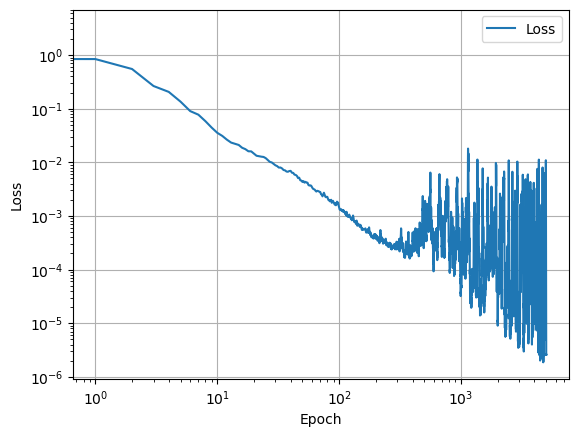

In [8]:
plt.plot(loss_data, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

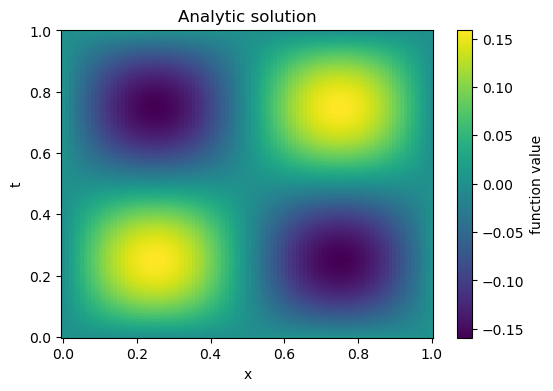

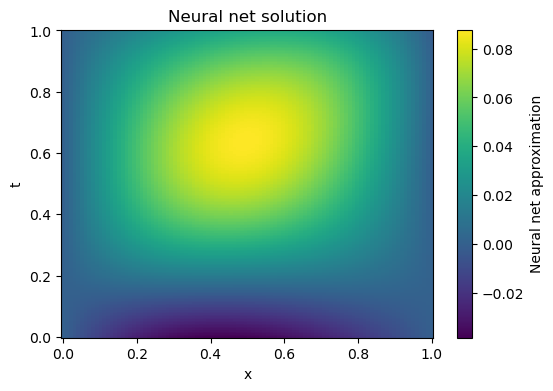

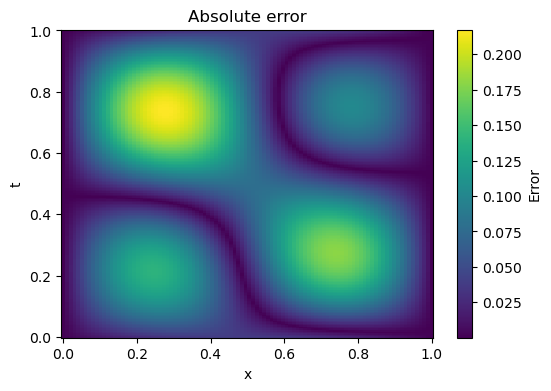

In [9]:
def analytic(x):
    # `x` = (x-coord, t-coord)
    return np.sin(2*np.pi*x[:,1])*np.sin(2*np.pi*x[:,0]) / (2*np.pi)

# Model testing
test_num_points_x = 100
test_num_points_t = 200
test_mesh_x, test_mesh_t = torch.meshgrid(torch.linspace(x_low, x_high, test_num_points_x, dtype=torch.float32), torch.linspace(t_low, t_high, test_num_points_t, dtype=torch.float32))
test_domain = torch.cat([test_mesh_x.reshape(-1, 1), test_mesh_t.reshape(-1, 1)], dim=1)

X = test_mesh_x.numpy()
T = test_mesh_t.numpy()

# Analytic solution
analytic_values = analytic(test_domain).reshape(test_num_points_x, test_num_points_t)
analytic_values = analytic_values.numpy()

plt.figure(figsize=(6,4))
plt.pcolormesh(X, T, analytic_values, cmap='viridis', shading='auto')
plt.colorbar(label='function value')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytic solution')
plt.show()

# Model solution
model_values = model(test_domain).detach().numpy().reshape(test_num_points_x, test_num_points_t)

plt.figure(figsize=(6,4))
plt.pcolormesh(X, T, model_values, cmap='viridis', shading='auto')
plt.colorbar(label='Neural net approximation')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Neural net solution')
plt.show()

# Error
error_values = np.abs(model_values - analytic_values)
plt.figure(figsize=(6,4))
plt.pcolormesh(X, T, error_values, cmap='viridis', shading='auto')
plt.colorbar(label='Error')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute error')
plt.show()